# Gold and USD inflation
Using monthly data we will explore the relationship between gold prices and
inflation.

### Inspirations
- [The FRED® Blog: Is gold a good hedge against inflation?]
(https://fredblog.stlouisfed.org/2019/03/is-gold-a-good-hedge-against-inflation/)

### Definitions
- Gold: The ICE Benchmark Administration Limited (IBA), Gold Fixing Price in
the London Bullion Market, based in U.S. Dollars, retrieved from FRED,
Federal Reserve Bank of St. Louis
- CPI inflation: Consumer Price Index, seasonally adjusted monthly since 1947,
, retrieved from FRED, Federal Reserve Bank of St. Louis
- PCE inflation: Personal Consumption Expenditure, seasonally adjusted monthly
since 1959, retrieved from FRED, Federal Reserve Bank of St. Louis
- SYN inflation: Synthetic Inflation, normalized and averaged over CPI,
CPI Core, PCE and PCE Core inflation measures, retrieved from FRED, Federal
Reserve Bank of St. Louis

### Dependencies:
- Python: datetime, fecon236, matplotlib, numpy, pandas, pandas_datareader,
sklearn, statsmodels, sympy, seaborn
- Written using Python 3.8.5, Atom 1.51, Hydrogen 2.14.4

### General To Do List:
- Understand cluster analysis in greater detail
- Review peer work

## 0. Preamble: Code Setup and Function Definitions

### Check if required modules are installed in the kernel; and if not install them

In [13]:
import sys
import subprocess
import pkg_resources
required = {'datetime', 'fecon236', 'matplotlib', 'numpy', 'pandas',
            'pandas_datareader', 'sklearn', 'statsmodels', 'sympy', 'seaborn'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed
if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing],
                           stdout=subprocess.DEVNULL)

0

In [14]:
# fecon236 is a useful econometrics python module for access and using U.S.
# Federal Reserve and related data
import fecon236 as fe
fe.system.specs()
#  If a module is modified, automatically reload it:
%load_ext autoreload
%autoreload 2   # Use 0 to disable this feature.

 !:  Code for this project straddles python27 and python3.
 ::  Python 3.8.5
 ::  IPython 7.18.1
 ::  jupyter_core 4.6.3
 ::  jupyter_client 6.1.7
 ::  notebook 6.1.4
 ::  matplotlib 3.3.1
 ::  numpy 1.19.2
 ::  scipy 1.5.2
 ::  statsmodels 0.12.0
 ::  sympy 1.6.2
 ::  pandas 1.1.2
 ::  pandas_datareader 0.9.0
 ::  fecon236 10.8.0
 ::  Repository: git_repo_None tag_None branch_None
 ::  Timestamp: 2020-09-22T18:50:23Z
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import useful modules for data wrangling

In [15]:
import numpy as np
import math
import datetime as dt

In [16]:
# Will use sklearn and statsmodels for model development and testing
from sklearn import mixture
from sklearn.cluster import OPTICS, cluster_optics_dbscan
# from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import MeanShift, estimate_bandwidth, MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
# from sklearn.datasets import make_blobs
import statsmodels.api as sm

In [17]:
# Notebook display and formatting options
# Represent pandas DataFrames as text; not HTML representation:
import pandas as pd
pd.set_option('display.notebook_repr_html', False)
# Alter Jupyter option for the pretty display of variables
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Import matplotlib and seaborn for plotting
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm   ### CAN WE GET RID OF THIS WITH SEABORN
#  Generate plots inside notebook, "inline" generates static png
%matplotlib inline
# Use seaborn for to make matplotlib pretty and set the default theme styles
import seaborn as sns
sns.set_theme()
sns.set_style("whitegrid")

In [18]:
# Module containing a series of helper functions for processing and displaying
# the data
import sys
sys.path.append('../lib/')
import tools as yt

In [19]:
# ### Variable Naming Schema:
# {series}_{type}_{period, optional}_{descriptor, optional}
# {series}
# dt    datetime
# in    inflation
# au    gold
#
# {type}
# idx   an index
# nom   nominal prices in USD
# rel   real (inflation adjusted) prices in USD
# lvl   levels e.g. prices, index values
# ppc   period on period percentage change
# fcd   fe module FRED codes
#
# {period}
# m     monthly
# y     yearly
#
# {descriptor}
# cln   column name
# var   variable identification

## 1. Retrieve Data, Determine Appropriate Start and End Dates for Analysis

In [20]:
# Get gold and inflation rates, both as monthly frequency
# Notes: fecon236 uses median to resample (instead of say mean) and also
# replaces FRED empty data (marked with a ".") with data from previously
# occurring period; These adjustments will drive some small differences to
# the analysis on the FRED blog

In [21]:
# Daily London AM gold fix, nominal USD, converted to monthly
dtau_nom_m = fe.monthly(fe.get('GOLDAMGBD228NLBM'))
# Daily London PM gold fix, nominal USD, converted to monthly
# au_nom_m = fe.get(fe.m4xau)
# Percentage calculation for month on month i.e. frequency = 1
freq = 1
dtau_nomppc_m = fe.nona(fe.pcent(dtau_nom_m, freq))

In [22]:
# Inflation in use
in_fcd = fe.m4cpi      # FRED code 'CPIAUCSL'
# in_fcd = fe.m4pce    # FRED code 'PCEPI'
# Synthetic average of 'CPIAUCSL', 'CPILFESL', 'PCEPI', 'CPILFESL'
# in_fcd = fe.m4infl
dtin_idx_m = fe.get (fe.m4cpi)        # Returns the index, not percentage change
dtin_ppc_m = fe.nona(fe.pcent(dtin_idx_m, freq))

In [23]:
# Gold with USD inflation removed i.e. in real USD
# First, calculate rebased inflation index
in_basedate = '2020-08-01'              # The base date for our index
in_base = dtin_idx_m['Y'][in_basedate]
dtin_idx_rebased = fe.div(dtin_idx_m, in_base)

In [24]:
# Find the first and last overlapping dates for the two data series where
# we are using values
dt_stp_lvl_m = max(fe.head(dtau_nom_m, 1).index[0],
                   fe.head(dtin_idx_m, 1).index[0])
dt_edp_lvl_m = min(fe.tail(dtau_nom_m, 1).index[0],
                   fe.tail(dtin_idx_m, 1).index[0])

In [25]:
# Calculate the real gold price
dtau_rel_m = fe.div(dtau_nom_m.loc[dt_stp_lvl_m:dt_edp_lvl_m],
                    dtin_idx_rebased.loc[dt_stp_lvl_m:dt_edp_lvl_m])
dtau_relppc_m = fe.nona(fe.pcent(dtau_rel_m, freq))

In [26]:
# Find the first and last overlapping dates for the two data series where we
# are using month on month percentage change
dt_stp_ppc_m = max(fe.head(dtau_relppc_m, 1).index[0], fe.head(dtin_ppc_m, 1).index[0])
dt_edp_ppc_m = min(fe.tail(dtau_relppc_m, 1).index[0], fe.tail(dtin_ppc_m, 1).index[0])

## 2. Plot and Review Time Series of Monthly Inflation and Gold Price Levels

In [27]:

# TODO: Plot time series charts: nominal au in USD vs inf index, real au in USD vs inf index

In [28]:
# TODO: Plot time series charts: change in: nominal au vs inf, real au vs inf

## 3. Plot and Review Change in Inflation and Gold Price Levels
### 3.1 Monthly Data

In [29]:
# Nominal USD data
dtinau_nomppc_m = pd.concat([dtin_ppc_m[dt_stp_ppc_m:dt_edp_ppc_m],
                             dtau_nomppc_m[dt_stp_ppc_m:dt_edp_ppc_m]], axis=1)
inau_nomppc_m_cln = 'Monthly Change in Inflation'
au_nomppc_m_cln = 'Monthly Change in Gold Price (Nom. USD)'
dtinau_nomppc_m.columns = [inau_nomppc_m_cln, au_nomppc_m_cln]

In [30]:
# Real USD data
dtinau_relppc_m = pd.concat([dtin_ppc_m[dt_stp_ppc_m:dt_edp_ppc_m],
                             dtau_relppc_m[dt_stp_ppc_m:dt_edp_ppc_m]], axis=1)
au_relppc_m_cln = 'Monthly Change in Gold Price (Real USD)'
dtinau_relppc_m.columns = [inau_nomppc_m_cln, au_relppc_m_cln]

In [31]:
# *Melt* the data together so we can display the charts side-by-side
dtinau_nomrelppc_m = dtinau_nomppc_m.join(dtinau_relppc_m.loc[:, dtinau_relppc_m.columns != inau_nomppc_m_cln],
                                          how='inner', sort=True)
dtinau_nomrelppc_m = pd.melt(dtinau_nomrelppc_m,
                             id_vars=inau_nomppc_m_cln,
                             value_vars=[au_nomppc_m_cln, au_relppc_m_cln])
au_var = 'Nominal or Real'
au_nomrelppc_cln = 'Monthly Change in Gold Price'
dtinau_nomrelppc_m.columns = [inau_nomppc_m_cln, au_var, au_nomrelppc_cln]

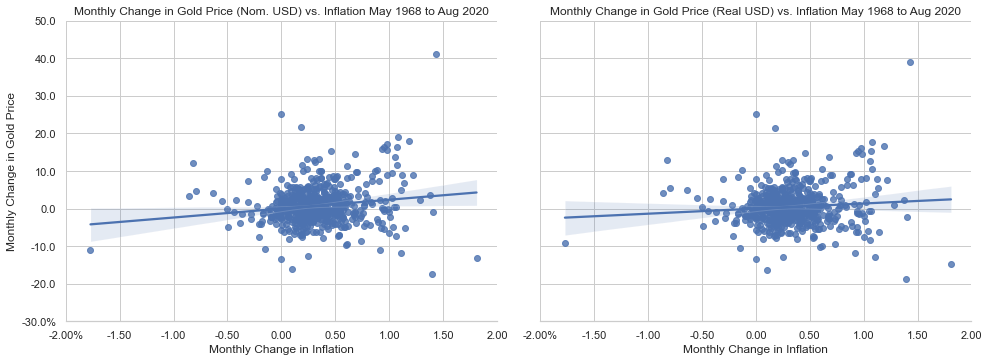

In [32]:
# Display the charts
fcg_nomrelppc_m = yt.snslmplot(data=dtinau_nomrelppc_m, xcol=inau_nomppc_m_cln,
                            ycol=au_nomrelppc_cln, yidcol=au_var, degree=1,
                            col_wrap=2)
plt_nomrelppc_m_title = ' vs. Inflation {} to {}'
plt_nomrelppc_m_title =  plt_nomrelppc_m_title.format(dt_stp_ppc_m.strftime("%b %Y"),
                                                      dt_edp_ppc_m.strftime("%b %Y"))
fcg_nomrelppc_m = fcg_nomrelppc_m.set_titles(col_template="{col_name}" + plt_nomrelppc_m_title)

**2020-09-22 Results Discussion** *(See Appendicies for Statistics)*

1. For nominal prices, the low correlation coefficient (~0.15), poor ability
of the model to explain movements (low R-squared and adjusted R-squareds of
~0.02) indicate that inflation explains only a small amount of the movement
in nominal gold prices. The t-stat and p-values are erroneously high as
changes in inflation will be included in the nominal price. To correct for
this we need to remove inflation and use real prices
2. For real prices, all model statistics show a weaker link as expected

### 3.2 Yearly Data

In [ ]:
# Change percentage calculation to every 12 months
freq = 12
dtau_relppc_y = fe.nona(fe.pcent(dtau_rel_m, freq))
dtin_ppc_y = fe.nona(fe.pcent(dtin_idx_m, freq))

In [ ]:
# Find the first and last overlapping dates for the two data series
dt_stp_ppc_y = max(fe.head(dtau_relppc_y, 1).index[0],
                   fe.head(dtin_ppc_y, 1).index[0])
dt_edp_ppc_y = min(fe.tail(dtau_relppc_y, 1).index[0],
                   fe.tail(dtin_ppc_y, 1).index[0])

In [ ]:
# Show same analysis as above
dtinau_relppc_y = pd.concat([dtin_ppc_y[dt_stp_ppc_y:dt_edp_ppc_y],
                             dtau_relppc_y[dt_stp_ppc_y:dt_edp_ppc_y]], axis=1)
in_ppc_y_cln = 'Yearly Inflation'
au_relppc_y_cln = 'Yearly Change in Gold Price (Real USD)'
dtinau_relppc_y.columns = [in_ppc_y_cln, au_relppc_y_cln]

In [ ]:
# Display the chart
fcg_relppc_y = yt.snslmplot(data=dtinau_relppc_y, xcol=in_ppc_y_cln,
                         ycol=au_relppc_y_cln, degree=1)
plt_relppc_y_title = 'Yearly Change in Gold Price (Real USD) vs. Inflation {} to {}'
plt_relppc_y_title =  plt_relppc_y_title.format(dt_stp_ppc_y.strftime("%b %Y"),
                                                dt_edp_ppc_y.strftime("%b %Y"))
for ax in fcg_relppc_y.axes.flat:
    fcg_relppc_y_ax = ax.set_title(plt_relppc_y_title)

**2020-09-22 Results Discussion** *(See Appendicies for Statistics)*

1. A correlation coefficient of ~0.31 and a significant t-stat for the
coefficient indicates that a yearly model is of better use than a monthly
view. However, the r-squared and adjusted r-squareds are still small (~0.1)
indicating that the model is missing many other factors in determing the
changes in gold price.
2. Of some interest is the group of data points in the upper right hand
side of the chart. Does this indicate that gold prices change significantly
when inflation is much higher than normal? Will explore higher order
polynomial models and cluster analysis to see if there is anything of
interest.

### 3.3 Yearly Data with Higher Order Polynomials

In [ ]:
for deg in range(2, 6):
    fcg_relppc_y = yt.snslmplot(data=dtinau_relppc_y, xcol=in_ppc_y_cln,
                             ycol=au_relppc_y_cln, degree=deg)
    for ax in fcg_relppc_y.axes.flat:
        fcg_relppc_y_ax = ax.set_title('Polynomial Order: {0}'.format(deg))

In [ ]:
# TODO: Change plotting method so that each plot is a subplot...use custom
# function with map? ref: https://seaborn.pydata.org/generated/seaborn.FacetGrid.html

**2020-09-22 Results Discussion** *(See Appendices for Statistics)*

Adding more features sees the statistics improve suggesting higher order
polynomial models are a better fit (see number discussion below). However, a
polynomial of order 2 or 4 are not intuitively obvious given their
implications of both high inflation and high deflation leading to a high
positive change in the gold price. Polynomials of order 1, 3 and 5 are
more intuitively understandable, with high inflation leading to a high
positive increase in gold prices, and high inflation leading to a high
negative decrease in gold prices.

The issue with higher order polynomials is one of over-fit, with the BIC
number indicating that order 3 may be the sweet spot.

Going with a order 3 polynomial model implies that gold prices do not
really do anything during low to moderate inflation (perhaps up to ~8%
just by eyeballing the data), but really takes off when inflation is high.

**So, in 2020, are we in the foreseeable future likely to have high inflation
reminiscent of the 1970's?** Unlikely in my view.

Model statistics detail: The r-squared and adjusted r-squared's move higher
to values of ~0.21 for `order=2`, to ~0.28 for `order=[3,4,5]`. The
coefficient t-starts and p-values are significant for `order=[2,3]`, but not
for 'order=[4,5]'. Reviewing the Bayesian Information Criterion (BIC),
indicates that 'order=3' is the preferred model. The Akaike Information
Criterion (AIC) indicates either 'order=[4,5]', with `order=3` a second
choice.

## 4 Cluster Analysis

In [ ]:
# Create NumPy array to hold data without the time series column
inau_relppc_y = np.column_stack((dtin_ppc_y['Y'][dt_stp_ppc_y:dt_edp_ppc_y], dtau_relppc_y['Y'][dt_stp_ppc_y:dt_edp_ppc_y]))

### 4.1 Expectation-Maximization

In [ ]:
# fit a GMM
n_cpts = 3
gmmmdl = mixture.GaussianMixture(n_components=n_cpts, covariance_type='full')
gmmmdl.fit(inau_relppc_y)
# display predicted scores by the model as a contour plot
xln = np.linspace(math.floor(min(inau_relppc_y[:, 0])),
                  math.ceil(max(inau_relppc_y[:, 0])))
yln = np.linspace(math.floor(min(inau_relppc_y[:, 1])),
                  math.ceil(max(inau_relppc_y[:, 1])))
Xln, Yln = np.meshgrid(xln, yln)
XX = np.array([Xln.ravel(), Yln.ravel()]).T
Zln = -gmmmdl.score_samples(XX)
Zln = Zln.reshape(Xln.shape);

In [ ]:
# Create and display the plot
fig = plt.figure(figsize=(12, 9))
CS = plt.contour(Xln, Yln, Zln, norm=LogNorm(vmin=1, vmax=100.0),
                 levels=np.logspace(0, 2, 25));
CB = plt.colorbar(CS, shrink=0.8);
fcg = plt.scatter(inau_relppc_y[:, 0], inau_relppc_y[:, 1], .8);
plt.show()
# TODO: Label axes
# TODO: Add title
# TODO: Do for n_cpts = [2, 3, 4, 6, 10]
# TODO: For multiple n_cpts, draw as subplots

2020-09-15: For `n_cpts = 2`, GMM essentially places a high likelihood
around the cluster of data centred on [3, 0] and doesn't pay much attention
to the rest. Not until `n_cpts ~ 10` does GMM lend any importance to
the data points in the upper left i.e. where this is a high change in
inflation and gold prices

### 4.2 K-Means

In [ ]:
# Compute the clustering with k-means
n_clusters = 4
ppc_y_kmeans = KMeans(init='k-means++',
                    n_clusters=n_clusters, n_init=10).fit(inau_relppc_y)
kmeans_cluster_centers = ppc_y_kmeans.cluster_centers_
kmeans_lbls = pairwise_distances_argmin(inau_relppc_y, kmeans_cluster_centers)

In [ ]:
# Plot the results
colours = sns.color_palette('muted')
fcg = plt.figure(figsize=(12, 9))
for k, col in zip(range(n_clusters), colours):
    my_members = kmeans_lbls == k
    cluster_center = kmeans_cluster_centers[k]
    fcg = plt.plot(inau_relppc_y[my_members, 0], inau_relppc_y[my_members, 1],
                   'w', markerfacecolor=col, marker='.')
    fcg = plt.plot(cluster_center[0], cluster_center[1], 'o',
                   markerfacecolor=col, markeredgecolor='k', markersize=6)
# TODO: Label axes
# TODO: Add title
# TODO: Do for n_clusters = [2, 3, 4, 5]
# TODO: For multiple n_clusters, draw as subplots

2020-09-15: For `n_clusters = 2`, k-means splits the data essentially along
horizontal axis, separating when the gold price change into two halves of
when it is positive vs. negative. For `n_clusters = 3`, the data is further
dissected along a horizontal line for gold change at approximately 50%.
A similar trend occurs for `n_clusters = 4` with a further horizontal
bisection. In summary, it is not obvious that horizontal clustering provides
any insight into the gold vs. inflation relationship

### 4.3 OPTICS

In [ ]:
# Define fit parameters
clust = OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.05)
# Run the fit
clust.fit(inau_relppc_y)
eps = 2.0
labels_200 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=eps);

In [ ]:
# Create and display the plot using OPTICS
fit = plt.figure(figsize=(12, 9))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
for klass, colour in zip(range(0, 5), colours):
    inau_relppc_y_k = inau_relppc_y[clust.labels_ == klass]
    fcg = ax1.plot(inau_relppc_y_k[:, 0], inau_relppc_y_k[:, 1], color=colour,
                 marker='o', ls='', alpha=0.3);
fcg = ax1.plot(inau_relppc_y[clust.labels_ == -1, 0],
         inau_relppc_y[clust.labels_ == -1, 1], 'k+', alpha=0.1);
title = ax1.set_title('Automatic Clustering: OPTICS')
# plt.show()
# DBSCAN at eps=2.
for klass, colour in zip(range(0, 4), colours):
    inau_relppc_y_k = inau_relppc_y[labels_200 == klass]
    fcg = ax2.plot(inau_relppc_y_k[:, 0], inau_relppc_y_k[:, 1], color=colour,
                   marker='o', ls='', alpha=0.3)
fcg = ax2.plot(inau_relppc_y[labels_200 == -1, 0],
               inau_relppc_y[labels_200 == -1, 1], 'k+', alpha=0.1);
title = 'Clustering at {0:.2f} epsilon cut: DBSCAN'.format(eps)
fcg = ax2.set_title(title)
plt.show()
# TODO: Label axes
# TODO: Do for eps = [0.5, 2]
# TODO: To explore and understand significance of changing min_samples=5,
# xi=0.05, min_cluster_size=0.05

2020-09-15: So similar to previous methods, clustering appears as horizontal
bisections

### 4.4 Mean-Shift (MS)

In [ ]:
# Calculate the MS
bandwidth = estimate_bandwidth(inau_relppc_y, quantile=0.25)
apc_ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
apc_ms.fit(inau_relppc_y)
lbls = apc_ms.labels_
cluster_centers = apc_ms.cluster_centers_
lbls_unique = np.unique(lbls)
n_clusters_ = len(lbls_unique);

In [ ]:
# Plot result
fig = plt.figure(figsize=(12, 9));
for k, colour in zip(range(n_clusters_), colours):
    my_members = lbls == k
    cluster_center = cluster_centers[k]
    fcg = plt.plot(inau_relppc_y[my_members, 0], inau_relppc_y[my_members, 1],
                   color=colour, marker='o', ls='', alpha=0.3)
    fcg = plt.plot(cluster_center[0], cluster_center[1], 'o',
                   markerfacecolor=colour, markeredgecolor='k', markersize=14)
title = plt.title('Estimated number of clusters: {}'.format(n_clusters_))
plt.show()
# TODO: Label axes
# TODO: Add title
# TODO: Do for quantile = [0.05, 0.1, 0.2, 0.25, 0.4]
# TODO: For multiple quantile, draw as subplots

2020-09-15: And so the same story continues, clustering appears as horizontal
bisections

## Appendices
### A.1 Inflation vs. nominal gold prices, monthly, polynomial order = 1

In [ ]:
yt.dispmodel(dtinau_nomppc_m)

### A.2 Inflation vs. real gold prices, monthly, polynomial order = 1

In [ ]:
yt.dispmodel(dtinau_relppc_m)

### A.3 Inflation vs. real gold prices, yearly, polynomial order = 1

In [ ]:
yt.dispmodel(dtinau_relppc_y)

### A.4 Inflation vs. real gold prices, yearly, polynomial order = 2

In [ ]:
yt.dispmodel(dtinau_relppc_y, degree=2)

### A.5 Inflation vs. real gold prices, yearly, polynomial order = 3

In [ ]:
yt.dispmodel(dtinau_relppc_y, degree=3)

### A.6 Inflation vs. real gold prices, yearly, polynomial order = 4

In [ ]:
yt.dispmodel(dtinau_relppc_y, degree=4)

### A.7 Inflation vs. real gold prices, yearly, polynomial order = 5

In [ ]:
yt.dispmodel(dtinau_relppc_y, degree=5)

### End Of File